## Boilerplate (run this first, only need to run once)

In [1]:
# TNAS v2021-12-16
# Nicholas A. Masluk
# nick@randombytes.net

# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this
# file, You can obtain one at https://mozilla.org/MPL/2.0/.

################################################################################
# Import modules
################################################################################

import numpy
import sys
import os
import tempfile
import shutil
import subprocess
import math
import scipy.integrate
import scipy.interpolate

################################################################################
# Physical constants
################################################################################

pi = numpy.pi
e = numpy.e

# Boltzmann constant
k_B = 1.3806488 * 10**-23
# Planck constant
h = 6.62606957 * 10**-34
# reduced Planck constant
hbar = h / (2 * pi)

################################################################################
# Function definitions
################################################################################

def eta(f, T):
    """Quantum correction factor for low temperature / high frequency."""
    return (h * f / (k_B * T)) / (e**(h * f / (k_B * T)) - 1)


def svv(f, T, Z):
    """Noise-voltage power spectral density in Volts^2 / Hz."""
    if str(type(Z)) == "<type 'function'>":
        return 4 * k_B * T * eta(f, T) * Z(f).real
    else:
        return  4 * k_B * T * eta(f, T) * Z.real


def sii(f, T, Y):
    """Noise-current power spectral density in Amps^2 / Hz."""
    if str(type(Y)) == "<type 'function'>":
        return 4 * k_B * T * eta(f, T) * Y(f).real
    else:
        return  4 * k_B * T * eta(f, T) * Y.real


def noise_temp_from_svv(f, svv, Z):
    """Get noise temperature from noise-voltage power spectral density.
    
    This is the noise that would appear across a resistor Re[Z] when attached
    to a mathced load of the same system (an open resistor will have double the
    noise temperature).
    """
    return h * f / (k_B * numpy.log((2 * h * f * Z.real) / svv + 1))


def round_sigfig(value, sig_figs):
    """Round according to significant figures."""
    if value == 0:
        return 0
    # Decade the most significant digit of the value sits in, with 0
    # corresponding to the one's place.
    decade_msd = int(math.floor(math.log10(abs(value))))
    # decade to be rounded to
    decade_round = decade_msd - sig_figs + 1
    return round(value, -decade_round)


# dict of metric prefixes representing 10^n, where n is the key (int)
metric_prefix_dict = {
24: 'Y',
21: 'Z',
18: 'E',
15: 'P',
12: 'T',
9: 'G',
6: 'M',
3: 'k',
0: '',
-3: 'm',
-6: 'µ',
-9: 'n',
-12: 'p',
-15: 'f',
-18: 'a',
-21: 'z',
-24: 'y'
}

def value_to_metric_string(value, sig_figs=4):
    value = round_sigfig(value, sig_figs)
    if value == 0:
        return '0 '
    # decade the value sits in, with 0 corresponding to one's place
    decade = int(math.floor(math.log10(abs(value))))
    # "engineering" decade the value sits in (multiple of 3)
    decade_eng = int(math.floor(decade/3.0) * 3)
    # bound decade_eng between 24 and -24
    if decade_eng > 24:
        decade_eng = 24
    elif decade_eng < -24:
        decade_eng = -24
    # get metric prefix
    prefix = metric_prefix_dict[decade_eng]
    # digits past the decimal
    digits_past_dec = max(0, sig_figs - decade + decade_eng - 1)
    # return formatted string
    return '%%.%df ' % digits_past_dec % (10**-decade_eng * value) + prefix


def _get_header(fname):
    """Read Spice3f5 raw file header information."""
    hdr = ''
    with open(fname, 'rb') as ff:
        while True:
            hdr += ff.readline().decode('ascii')
            if hdr[-8:] == 'Binary:\n':
                break
            if hdr[-8:] == 'Values:\n':
                #break
                raise Exception('Raw file is ASCII, only binary is supported.')
    return hdr


def _get_variables_from_header(hdr):
    """Parse out variables from Spice3f5 raw file header (forced lower case)."""
    # pull off stuff after Variables:\n
    hdr_vars = hdr.split('Variables:\n')[1]
    # divide at \n
    hdr_vars = hdr_vars.split('\n')
    # remove 'Binary:' and '' (or 'Values:' and '')
    hdr_vars = hdr_vars[:-2]
    variables = []
    for line in hdr_vars:
        # ngspice separates line parameters with tabs, wrspice with spaces.
        # Frist character in line is a delimiter, so use it to split
        delimiter = line[0]
        variables.append(line.split(delimiter)[2].lower())
    # number of variables stated in the header
    num_variables = int(hdr.split('No. Variables: ')[1].split('\n')[0])
    # make sure the number of stated variables matches the number listed
    if len(variables) != num_variables:
        raise Exception(
        'Number of variables listed does not match "No. Variables %d": %d' %
                        (num_variables, len(variables)))
    return variables


def import_spice_raw(fname, verbose=False):
    """Read in Spice3f5 raw file."""
    # simple checks on supplied filename
    if not os.path.exists(fname):
        raise Exception('File does not exist:\n' + fname)
    if not os.path.isfile(fname):
        raise Exception('Not a file:\n' + fname)

    hdr = _get_header(fname)
    # offset index for binary data, starts after header
    offset = len(hdr)
    # data is little endian 64 bit float
    # each value as given as a real and imaginary 64-bit float pair

    num_variables = int(hdr.split('No. Variables: ')[1].split('\n')[0])
    num_points = int(hdr.split('No. Points: ')[1].split('\n')[0])
    variables = _get_variables_from_header(hdr)

    # import data file
    if verbose:
        sys.stdout.write('\rLoading file')
    try:
        data = numpy.fromfile(fname, dtype=numpy.float64, count=-1, sep='',
                              offset=offset)
    except TypeError:
        # offset parameter only exists in numpy.fromfile since numpy 1.17.0
        # import as 8-bit bytes
        data = numpy.fromfile(fname, dtype=numpy.int8, count=-1, sep='')
        # remove offset, and convert data to 64-bit floats
        data = numpy.frombuffer(data[offset:], dtype=numpy.float64)

    # make sure length of imported data matches expectation from header
    # information
    if len(data) != num_variables * 2 * num_points:
        raise Exception('Length of imported data (%i) does not match header (%i)'
                        % (len(data), num_variables * 2 * num_points))

    if verbose:
        sys.stdout.write('\rFormatting data')
        sys.stdout.flush()
    # split up single array into a list of arrays
    data = numpy.transpose(data.reshape(num_points, num_variables * 2))
    data_list = numpy.vsplit(data, num_variables * 2)

    data_dict = {}
    for ii, vr in enumerate(variables):
        # combine real and imaginary parts to a single complex number
        data_dict[vr] = data_list[ii*2][0] + 1j * data_list[ii*2 + 1][0]

    if verbose:
        sys.stdout.write('\rDone           \n')
    return data_dict


def _parse_spice_line(line):
    """Parse SPICE netlist line, stripping away white space."""
    line_parsed = line.strip()
    return line_parsed


def _parse_ads_line(line):
    """Parse through ADS netlist line and return conversion to SPICE."""
    if line[0] == ';':
        # comment
        return '*' + line[1:]
        
    if len(line.split(':')) != 2:
        # not a component, ignore line
        return ''

    part_type = line.split(':')[0]

    if part_type == 'tf':
        raise Exception(
      'Transformers are not supported, use mutually coupled inductors instead.')
    elif part_type in ['R', 'L', 'C']:
        # resistor, inductor, or capacitor
        refdes = line.split(' ')[0].split(':')[1]
        if refdes[0].upper() != part_type:
            # refdes must start with "R", "L", or "C"
            refdes = part_type + refdes
        node1 = line.split(' ')[2]
        node2 = line.split(' ')[3]
        if part_type == 'R':
            suffix = line.split(' ')[5].split('Ohm')[0]
        if part_type == 'L':
            suffix = line.split(' ')[5].split('H')[0]
        if part_type == 'C':
            suffix = line.split(' ')[5].split('F')[0]
        if suffix == 'M':
            # in ADS, "M" is mega, "m" is milli.  "Meg" also works in ADS,
            # but we only need to watch for "M" here.
            suffix = 'MEG'
        value = line.split(' ')[4][2:] + suffix
        return ('%s %s %s %s' % (refdes, node1, node2, value))
    elif part_type == 'Port':
        # replace port with equivalent resistor
        #TODO can ports in ADS have complex impedance?
        refdes = line.split(' ')[0]
        node1 = line.split(' ')[2]
        node2 = line.split(' ')[3]
        suffix = line.split(' ')[6].split('Ohm')[0]
        value = line.split(' ')[5][2:] + suffix
        # make sure value is not complex
        if value[0] not in map(str, range(10)):
            raise Exception('Complex port impedances not supported: %s'
                            % refdes)
        # values can be complex
        return 'R_%s %s %s %s' % (refdes, node1, node2, value)
    elif part_type == 'I_Source':
        # leave current sources as opens
        return ''
    elif part_type == 'V_Source':
        # replace voltage sources with shorts; zero ohm resistors
        refdes = line.split(' ')[0]
        node1 = line.split(' ')[2]
        node2 = line.split(' ')[3]
        return 'R_%s %s %s 0' % (refdes, node1, node2)
    elif part_type == 'Mutual':
        # mutual inductance between inductors
        refdes = line.split(' ')[0]
        k12 = line.split(' ')[2][2:]
        l1_refdes = line.split(' ')[3].split('="')[1][:-1]
        l2_refdes = line.split(' ')[4].split('="')[1][:-1]
        return 'K_%s %s %s %s' % (refdes, l1_refdes, l2_refdes, k12)
    elif part_type == 'TLIN':
        # ideal transmission line
        refdes = line.split(' ')[0]
        node1 = line.split(' ')[2]
        node3 = line.split(' ')[3]
        z0_suffix = line.split(' ')[5].split('Ohm')[0]
        z0 = line.split(' ')[4][2:] + z0_suffix
        # SPICE takes a delay time, ADS uses phase change at at a frequency
        # phase in degrees
        phase = line.split(' ')[6][2:]
        freq_suffix = line.split(' ')[8].split('Hz')[0]
        freq = line.split(' ')[7][2:] + freq_suffix
        # convert to delay in nanoseconds
        dly = spice_value_to_numeric(phase) / 360. / \
              spice_value_to_numeric(freq) * 1e9
        # nodes 2 and 4 are always ground
        return 'T_%s %s 0 %s 0 Td=%sn Z0=%s' % (refdes, node1, node3, dly, z0)

    raise Exception('Component type not supported: %s' % part_type)


# See https://qucs-help.readthedocs.io/en/latest/mathfunc.html#number-suffixes
qucs_suffix_dict = {
'E': 1e18,
'P': 1e15,
'T': 1e12,
'G': 1e9,
'M': 1e6,
'k': 1e3,
'm': 1e-3,
'u': 1e-6,
'n': 1e-9,
'p': 1e-12,
'f': 1e-15,
'a': 1e-18
}

# dict of [value_type]
qucs_units_dict = {
'R': 'Ohm',
'L': 'H',
'C': 'F',
'alpha': 'dB',
'length': 'm',
'Z': 'Ohm',
}

def _interpret_qucs_value(param_value, value_type):
    """Detrermine the SPICE value and suffix of a QUCS value.
    
    param_value is the full value string, which looks like 'R="10 kOhm"'
    value_type defines the units to be used with qucs_units_dict.
    
    This is difficult in QUCS, as the rules are ambiguous and undocumented (at
    least I couldn't find any).  The rules below have been found empirically.
    
    Units may or may not be included.
    
    There may be any number of spaces between the numeric value and metric
    prefix, and metric prefix and unit, and padding either side of the value.
    
    Metric prefixes range from 'E' to 'a', and are case sensitive.
    
    Where a metric prefix is the same as a unit (for example, 'm' for milli or
    meter), the metric prefix takes priority.  So, a transmission line of
    length '10 m' is 10 millimeters, not 10 meters.
    """
    # remove all spaces and quotes
    param_value = param_value.replace(' ', '').replace('"', '')
    # determine the units for this value
    units = qucs_studio_units_dict[value_type]
    # see if param_value ends with units; remove units if so
    if len(param_value) > len(units):
        if param_value[-len(units):] == units:
            # remove units and return value, unless units are 'm' and no
            # metric prefix is given to the unit (in which case 'm' means
            # milli, not meters)
            if units == 'm' and param_value[-2] not in qucs_studio_prefix_dict:
                pass
            else:
                param_value = param_value[:-len(units)]
    # convert value string to a float
    # see if value ends with a multiplier
    if param_value[-1] in qucs_studio_prefix_dict:
        multiplier = qucs_studio_prefix_dict[param_value[-1]]
        return float(param_value[:-1]) * multiplier
    return float(param_value)


def _parse_qucs_line(line):
    """Parse through QUCS netlist line and return conversion to SPICE."""
    if line[0] == '#':
        # comment
        return '*' + line[1:]
        
    if len(line.split(':')) != 2:
        # not a component, ignore line
        return ''

    part_type = line.split(':')[0]

    if part_type == 'Tr':
        raise Exception(
      'Transformers are not supported, use mutually coupled inductors instead.')
    elif part_type in ['R', 'L', 'C']:
        # resistor, inductor, or capacitor
        refdes = line.split(' ')[0].split(':')[1]
        if refdes[0].upper() != part_type:
            # refdes must start with "R", "L", or "C"
            refdes = part_type + refdes
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        param_value = line.split('"')[1]
        value = _interpret_qucs_value(param_value, part_type)
        return ('%s %s %s %e' % (refdes, node1, node2, value))
    elif part_type in ['Iac', 'Idc']:
        # leave current sources as opens
        return ''
    elif part_type in ['Vac', 'Vdc']:
        # replace voltage sources with shorts; zero ohm resistors
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        return 'R_%s %s %s 0' % (refdes, node1, node2)
    elif part_type == 'MUT':
        # mutual inductance between inductors
        refdes = line.split(' ')[0].split(':')[1]
        l1_node1 = line.split(' ')[1]
        l2_node1 = line.split(' ')[2]
        l1_node2 = line.split(' ')[3]
        l2_node2 = line.split(' ')[4]
        # make some inductor reference designators
        l1_refdes = 'L_%s_1' % refdes
        l2_refdes = 'L_%s_2' % refdes
        # get L1 value
        l1_param_value = line.split('"')[1]
        l1_value = _interpret_qucs_value(l1_param_value, 'L')
        # get L2 value
        l2_param_value = line.split('"')[3]
        l2_value = _interpret_qucs_value(l2_param_value, 'L')
        # coupling constant
        k12 = line.split('"')[5]
        return ['%s %s %s %e' % (l1_refdes, l1_node1, l1_node2, l1_value),
                '%s %s %s %e' % (l2_refdes, l2_node1, l2_node2, l2_value),
                'K_%s %s %s %s' % (refdes, l1_refdes, l2_refdes, k12)]
    elif part_type == 'MUT2':
        # mutual inductance between three inductors
        refdes = line.split(' ')[0].split(':')[1]
        l1_node1 = line.split(' ')[1]
        l2_node1 = line.split(' ')[2]
        l2_node2 = line.split(' ')[3]
        l3_node2 = line.split(' ')[4]
        l3_node1 = line.split(' ')[5]
        l1_node2 = line.split(' ')[6]
        # make some inductor reference designators
        l1_refdes = 'L_%s_1' % refdes
        l2_refdes = 'L_%s_2' % refdes
        l3_refdes = 'L_%s_3' % refdes
        # get L1 value
        l1_param_value = line.split('"')[1]
        l1_value = _interpret_qucs_value(l1_param_value, 'L')
        # get L2 value
        l2_param_value = line.split('"')[3]
        l2_value = _interpret_qucs_value(l2_param_value, 'L')
        # get L3 value
        l3_param_value = line.split('"')[5]
        l3_value = _interpret_qucs_value(l3_param_value, 'L')
        # coupling constants
        k12 = line.split('"')[7]
        k13 = line.split('"')[9]
        k23 = line.split('"')[11]
        return ['%s %s %s %e' % (l1_refdes, l1_node1, l1_node2, l1_value),
                '%s %s %s %e' % (l2_refdes, l2_node1, l2_node2, l2_value),
                '%s %s %s %e' % (l3_refdes, l3_node1, l3_node2, l3_value),
                'K_%s %s %s %s' % (refdes + '_12', l1_refdes, l2_refdes, k12),
                'K_%s %s %s %s' % (refdes + '_13', l1_refdes, l3_refdes, k13),
                'K_%s %s %s %s' % (refdes + '_23', l2_refdes, l3_refdes, k23)]
    elif part_type == 'MUTX':
        # mutual inductance between multiple inductors
        refdes = line.split(' ')[0].split(':')[1]
        l_node_list = line.split(' L="')[0].split(' ')[1:]
        l_param_value_list = line.split(' L="[')[1].split(']" ')[0].split(';')
        l_value_list = list(map(lambda vv: _interpret_qucs_value(vv, 'L'),
                           l_param_value_list))
        k_list = line.split(' k="[')[1].split(']"')[0].split(';')
        # list of SPICE lines
        spice_lines = []
        # make inductors
        for ii in range(len(l_value_list)):
            l_refdes = 'L_%s_%d' % (refdes, ii + 1)
            node1 = l_node_list[2*ii]
            node2 = l_node_list[2*ii + 1]
            value = l_value_list[ii]
            spice_lines.append('%s %s %s %e' % (l_refdes, node1, node2, value))
        # make couplings between inductors
        for ii in range(1, 1 + len(l_value_list)):
            for jj in range(ii + 1, 1 + len(l_value_list)):
                k_refdes = '%s_%d_%d' % (refdes, ii, jj)
                li_refdes = '%s_%d' % (refdes, ii)
                lj_refdes = '%s_%d' % (refdes, jj)
                kk = k_list[(ii - 1) + (jj - 1)*len(l_value_list)]
                spice_lines.append('K_%s %s %s %s' %
                                          (k_refdes, li_refdes, lj_refdes, kk))
        return spice_lines
    elif part_type == 'TLIN':
        # 2 port transmission line
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node3 = line.split(' ')[2]
        z0_value = line.split('"')[1]
        z0 = _interpret_qucs_value(z0_value, 'Z')
        # SPICE takes a delay time, QUCS uses length
        len_value = line.split('"')[3]
        length = _interpret_qucs_value(len_value, 'length')
        # convert to delay in nanoseconds
        dly = length / 299792458 * 1e9
        # make sure loss has not been added
        alpha_value = line.split('"')[5]
        alpha = _interpret_qucs_value(alpha_value, 'alpha')
        if float(alpha) != 0:
            raise Exception('Lossy transmission lines are not supported.')
        # nodes 2 and 4 are always ground
        return 'T_%s %s 0 %s 0 Td=%en Z0=%e' % (refdes, node1, node3, dly, z0)
    elif part_type == 'TLIN4P':
        # 4 port transmission line
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        node3 = line.split(' ')[3]
        node4 = line.split(' ')[4]
        z0_value = line.split('"')[1]
        z0 = _interpret_qucs_value(z0_value, 'Z')
        # SPICE takes a delay time, QUCS uses length
        len_value = line.split('"')[3]
        length = _interpret_qucs_value(len_value, 'length')
        # convert to delay in nanoseconds
        dly = length / 299792458 * 1e9
        # make sure loss has not been added
        alpha_value = line.split('"')[5]
        alpha = _interpret_qucs_value(alpha_value, 'alpha')
        if float(alpha) != 0:
            raise Exception('Lossy transmission lines are not supported.')
        return 'T_%s %s %s %s %s Td=%en Z0=%e' % \
                (refdes, node1, node2, node3, node4, dly, z0)

    raise Exception('Component type not supported: %s' % part_type)


qucs_studio_prefix_dict = {
'T': 1e12,
'G': 1e9,
'M': 1e6,
'k': 1e3,
'c': 1e-2,
'm': 1e-3,
'u': 1e-6,
'µ': 1e-6,
'n': 1e-9,
'p': 1e-12,
'f': 1e-15,
'mil': 2.54e-5,
}

# dict of [value_type]
qucs_studio_units_dict = {
'R': 'Ohm',
'L': 'H',
'C': 'F',
'alpha': 'dB',
'length': 'm',
'Z': 'Ohm',
}

def _interpret_qucs_studio_value(param_value, value_type):
    """Detrermine the SPICE value and suffix of a QUCS value.
    
    param_value is the full value string, which looks like '"10 kOhm"'
    value_type defines the units to be used with qucs_studio_units_dict.
    
    This is difficult in QUCS, as the rules are ambiguous and undocumented (at
    least I couldn't find any).  The rules below have been found empirically.
    
    Units may or may not be included.  See "Prefix (not for diagrams)" under
    "Mathematical Functions (in Diagrams and Components)" of QucsStudio Help.
    
    There may be any number of spaces between the numeric value and metric
    prefix, and padding either side of the value. There can be no space between
    the metric prefix and unit.
    
    Metric prefixes range from 'T' to 'f', and are case sensitive.
    
    Where a metric prefix is the same as a unit (for example, 'm' for milli or
    meter), the metric prefix takes priority.  So, a transmission line of
    length '10 m' is 10 millimeters, not 10 meters.
    """
    # remove all spaces and quotes
    param_value = param_value.replace(' ', '').replace('"', '')
    # determine the units for this value
    units = qucs_studio_units_dict[value_type]
    # see if param_value ends with units; remove units if so
    if len(param_value) > len(units):
        if param_value[-len(units):] == units:
            # remove units and return value, unless units are 'm' and no
            # metric prefix is given to the unit (in which case 'm' means
            # milli, not meters)
            if units == 'm' and param_value[-2] not in qucs_studio_prefix_dict:
                pass
            else:
                param_value = param_value[:-len(units)]
    # convert value string to a float
    # see if value ends with a multiplier
    if param_value[-3:] == 'mil':
        multiplier = qucs_studio_prefix_dict['mil']
        return float(param_value[:-1]) * multiplier
    if param_value[-1] in qucs_studio_prefix_dict:
        multiplier = qucs_studio_prefix_dict[param_value[-1]]
        return float(param_value[:-1]) * multiplier
    return float(param_value)


def _parse_qucs_studio_line(line):
    """Parse through QucsStuido netlist line and return conversion to SPICE."""
    if line[0] == '#':
        # comment
        return '*' + line[1:]
        
    if len(line.split(':')) != 2:
        # not a component, ignore line
        return ''

    part_type = line.split(':')[0]

    if part_type == 'Tr':
        raise Exception(
      'Transformers are not supported, use mutually coupled inductors instead.')
    elif part_type in ['R', 'L', 'C']:
        # resistor, inductor, or capacitor
        refdes = line.split(' ')[0].split(':')[1]
        if refdes[0].upper() != part_type:
            # refdes must start with "R", "L", or "C"
            refdes = part_type + refdes
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        param_value = ''.join(line.split('"')[1])
        value = _interpret_qucs_studio_value(param_value, part_type)
        return ('%s %s %s %e' % (refdes, node1, node2, value))
    elif part_type in ['Iac', 'Idc', 'Inoise']:
        # leave current sources as opens
        return ''
    elif part_type in ['Vac', 'Vdc', 'Vnoise']:
        # replace voltage sources with shorts; zero ohm resistors
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        return 'R_%s %s %s 0' % (refdes, node1, node2)
    elif part_type == 'MUT':
        # mutual inductance between inductors
        refdes = line.split(' ')[0].split(':')[1]
        l1_node1 = line.split(' ')[1]
        l2_node1 = line.split(' ')[2]
        l1_node2 = line.split(' ')[3]
        l2_node2 = line.split(' ')[4]
        # make some inductor reference designators
        l1_refdes = 'L_%s_1' % refdes
        l2_refdes = 'L_%s_2' % refdes
        # get L1 value
        l1_param_value = line.split('"')[1]
        l1_value = _interpret_qucs_value(l1_param_value, 'L')
        # get L2 value
        l2_param_value = line.split('"')[3]
        l2_value = _interpret_qucs_value(l2_param_value, 'L')
        # coupling constant
        k12 = line.split('"')[5]
        # get series resistances
        l1_r_param_value = line.split('"')[7]
        l2_r_param_value = line.split('"')[9]
        if l1_r_param_value != '0' or l2_r_param_value != '0':
            raise Exception('Use external resistor for series resistance on %s'
                            % refdes)
        return ['%s %s %s %e' % (l1_refdes, l1_node1, l1_node2, l1_value),
                '%s %s %s %e' % (l2_refdes, l2_node1, l2_node2, l2_value),
                'K_%s %s %s %s' % (refdes, l1_refdes, l2_refdes, k12)]
    elif part_type == 'MUT2':
        # mutual inductance between three inductors
        refdes = line.split(' ')[0].split(':')[1]
        l1_node1 = line.split(' ')[1]
        l2_node1 = line.split(' ')[2]
        l2_node2 = line.split(' ')[3]
        l3_node2 = line.split(' ')[4]
        l3_node1 = line.split(' ')[5]
        l1_node2 = line.split(' ')[6]
        # make some inductor reference designators
        l1_refdes = 'L_%s_1' % refdes
        l2_refdes = 'L_%s_2' % refdes
        l3_refdes = 'L_%s_3' % refdes
        # get L1 value
        l1_param_value = line.split('"')[1]
        l1_value = _interpret_qucs_value(l1_param_value, 'L')
        # get L2 value
        l2_param_value = line.split('"')[3]
        l2_value = _interpret_qucs_value(l2_param_value, 'L')
        # get L3 value
        l3_param_value = line.split('"')[5]
        l3_value = _interpret_qucs_value(l3_param_value, 'L')
        # coupling constants
        k12 = line.split('"')[7]
        k13 = line.split('"')[9]
        k23 = line.split('"')[11]
        # get series resistances
        l1_r_param_value = line.split('"')[13]
        l2_r_param_value = line.split('"')[15]
        l3_r_param_value = line.split('"')[17]
        if l1_r_param_value != '0' or l2_r_param_value != '0' \
           or l3_r_param_value != '0':
            raise Exception('Use external resistor for series resistance on %s'
                            % refdes)
        return ['%s %s %s %e' % (l1_refdes, l1_node1, l1_node2, l1_value),
                '%s %s %s %e' % (l2_refdes, l2_node1, l2_node2, l2_value),
                '%s %s %s %e' % (l3_refdes, l3_node1, l3_node2, l3_value),
                'K_%s %s %s %s' % (refdes + '_12', l1_refdes, l2_refdes, k12),
                'K_%s %s %s %s' % (refdes + '_13', l1_refdes, l3_refdes, k13),
                'K_%s %s %s %s' % (refdes + '_23', l2_refdes, l3_refdes, k23)]
    elif part_type == 'MUTn':
        # mutual inductance between multiple inductors
        refdes = line.split(' ')[0].split(':')[1]
        l_node_list = line.split('"')[0].split(' ')[1:-1]
        # list of inductance and coupling values, interlaced with spaces
        # first number in quotes is the number of inductors present
        values = line.split('"')[3:]
        # number of inductors
        num_l = int(len(l_node_list)/2)
        # make list of inductance values
        l_value_list = []
        for ii in range(num_l):
            l_value = _interpret_qucs_studio_value(values[ii * 2], 'L')
            l_value_list.append(l_value)
        # make list of couplings
        k_list = []
        # number of couplings
        nn = num_l - 1
        num_k = int((nn**2 + nn) / 2)
        for ii in range(num_k):
            k_list.append(values[(ii + num_l) * 2])
        # list of SPICE lines
        spice_lines = []
        # make inductors
        for ii in range(len(l_value_list)):
            l_refdes = 'L_%s_%d' % (refdes, ii + 1)
            node1 = l_node_list[2*ii]
            node2 = l_node_list[2*ii + 1]
            value = l_value_list[ii]
            spice_lines.append('%s %s %s %e' % (l_refdes, node1, node2, value))
        # make couplings between inductors
        k_iter = 0
        for ii in range(1, 1 + len(l_value_list)):
            for jj in range(ii + 1, 1 + len(l_value_list)):
                k_refdes = '%s_%d_%d' % (refdes, ii, jj)
                li_refdes = '%s_%d' % (refdes, ii)
                lj_refdes = '%s_%d' % (refdes, jj)
                kk = k_list[k_iter]
                k_iter += 1
                spice_lines.append('K_%s %s %s %s' %
                                          (k_refdes, li_refdes, lj_refdes, kk))
        return spice_lines
    elif part_type == 'TLIN':
        # 2 port transmission line
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node3 = line.split(' ')[2]
        z0_value = line.split('"')[1]
        z0 = _interpret_qucs_studio_value(z0_value, 'Z')
        # SPICE takes a delay time, QucsStudio uses length
        qucs_len_value = line.split('"')[3]
        length = _interpret_qucs_studio_value(qucs_len_value, 'length')
        # convert to delay in nanoseconds
        dly = length / 299792458 * 1e9
        # make sure loss has not been added
        alpha_value = line.split('"')[5]
        alpha = _interpret_qucs_studio_value(alpha_value, 'alpha')
        if float(alpha) != 0:
            raise Exception('Lossy transmission lines are not supported.')
        # nodes 2 and 4 are always ground
        return 'T_%s %s 0 %s 0 Td=%en Z0=%e' % (refdes, node1, node3, dly, z0)
    elif part_type == 'TLIN4P':
        # 4 port transmission line
        refdes = line.split(' ')[0].split(':')[1]
        node1 = line.split(' ')[1]
        node2 = line.split(' ')[2]
        node3 = line.split(' ')[3]
        node4 = line.split(' ')[4]
        z0_value = line.split('"')[1]
        z0 = _interpret_qucs_studio_value(z0_value, 'Z')
        # SPICE takes a delay time, QucsStudio uses length
        len_value = line.split('"')[3]
        length = _interpret_qucs_studio_value(len_value, 'length')
        # convert to delay in nanoseconds
        dly = length / 299792458 * 1e9
        # make sure loss has not been added
        alpha_value = line.split('"')[5]
        alpha = _interpret_qucs_studio_value(alpha_value, 'alpha')
        if float(alpha) != 0:
            raise Exception('Lossy transmission lines are not supported.')
        return 'T_%s %s %s %s %s Td=%en Z0=%e' % \
                (refdes, node1, node2, node3, node4, dly, z0)

    raise Exception('Component type not supported: %s' % part_type)


parsers = {
'*': (_parse_spice_line, 'SPICE'),
';': (_parse_ads_line, 'Keysight ADS'),
'# Qucs ': (_parse_qucs_line, 'QUCS'),
'# QucsStudio ': (_parse_qucs_studio_line, 'QucsStudio'),
}

def get_parser(title_line):
    """Determine what what parser to use, and the type of netlist."""
    for key in parsers.keys():
        if title_line[:len(key)] == key:
            return parsers[key]
    raise Exception('Cannot determine netlist type from title:\n%s'
                    % title_line +
     'Make sure QUICS and QuicsStudio titles start with "# Qucs " or "# QucsStuido ".')


def check_netlist_support(netlist):
    """Raise exception if netlist contains an unsupported electrical element."""
    for line in netlist:
        if line[0].upper() not in ['*', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                                   'R', 'T', 'V']:
            raise Exception('Unsupported electrical element: %s' % line)


def parse_netlist_line(line):
    """Separate parameters in netlist line."""
    param_list = []
    for param in line.strip().replace('\t', ' ').split(' '):
        if param.strip() != '':
            param_list.append(param)
    return param_list


def get_line_nodes(line):
    """Get the node names from SPICE line, returned as a list.
    
    Note that nodes on transmission lines are ignored!"""
    params = parse_netlist_line(line)
    if line[0].upper() in ['B', 'C', 'D', 'I', 'L', 'R', 'V', 'W']:
        # 2 node devices
        return list(map(str.upper, params[1:3]))
    if line[0].upper() in ['J', 'Q', 'U', 'Z']:
        # 3 node devices
        return list(map(str.upper, params[1:3]))
    if line[0].upper() in ['E', 'F', 'G', 'H', 'M', 'O', 'S', 'T', 'Y']:
        # 4 node devices
        return list(map(str.upper, params[1:5]))
    # Ignore other lines, like coupled inductors 'K', comments, '.end'.
    return []


def rename_node(line, node_from, node_to):
    """Rename node name in netlist line."""
    params = parse_netlist_line(line)
    if line[0].upper() in ['B', 'C', 'D', 'I', 'L', 'R', 'V', 'W']:
        # 2 node devices
        for ii in [1, 2]:
            if params[ii].upper() == node_from.upper():
                params[ii] = node_to
    if line[0].upper() in ['J', 'Q', 'U', 'Z']:
        # 3 node devices
        for ii in [1, 2, 3]:
            if params[ii].upper() == node_from.upper():
                params[ii] = node_to
    if line[0].upper() in ['E', 'F', 'G', 'H', 'M', 'O', 'S', 'T', 'Y']:
        # 4 node devices
        for ii in [1, 2, 3, 4]:
            if params[ii].upper() == node_from.upper():
                params[ii] = node_to
    # ignore other lines, like coupled inductors 'K'
    # join adjusted parameters as a new line
    new_line = params[0]
    for param in params[1:]:
        new_line += ' %s' % param
    return new_line


def establish_ground(netlist):
    """Ensure that there is a '0' node."""
    nodes = set()
    for line in netlist:
        new_nodes = get_line_nodes(line)
        if line[0].upper() in ['T', 'O']:
            # On transmission lines, ignore nodes 2 and 4, as ADS, QUCS and
            # and QucsStudio have a grounded TLIN element, and during the
            # SPICE netlist conversion process in this program, the two grounded
            # nodes are explicitly labeled as '0'.  So, skip over those nodes
            # here so as not to falsely add '0' to the list.
            new_nodes = [new_nodes[0], new_nodes[2]]
        for node in new_nodes:
            nodes.add(node.upper())
    if '0' in nodes:
        # '0' node exists, nothing left to do
        return netlist
    if 'GND' not in nodes:
        # there is no '0' or 'GND' node
        raise Exception('No ground node exists in netlist ("0" or "GND").')
    # '0' does not exist, but 'GND' does; rename 'GND' as '0'
    netlist_0 = []
    for line in netlist:
        netlist_0.append(rename_node(line, 'GND', '0'))
    return netlist_0


def clean_node_names(netlist):
    """Rename nodes to ensure no issues with any version of SPICE."""
    # As an examlpe of node name issues, ngspice on Windows will not
    # support "-" in nodes (but the Linux version will), and Eeschema netlists
    # contain "-" unless "Use net number as net name" is selected.  However,
    # when "Use net number as net name" is used, the ground net can be any
    # integer >=1, which is a bigger problem.
    
    # get all nodes in the netlist
    nodes = set()
    for line in netlist:
        for node in get_line_nodes(line):
            nodes.add(node.upper())
    if '0' not in nodes:
        raise Exception('Netlist does not contain "0" node; bug in code.')
    nodes.remove('0')
    
    # make a dictionary of new node names
    node_dict = {}
    for ii, node_old in enumerate(nodes):
        node_dict[node_old] = 'node_%d' % (ii + 1)

    # make netlist with new node names
    netlist_clean_nodes = []
    for line in netlist:
        for node in get_line_nodes(line):
            if node == '0':
                # do not change "0" node
                continue
            # replace old node name with new node name in line
            line = rename_node(line, node, node_dict[node])
        # append line with updated node names
        netlist_clean_nodes.append(line)

    return netlist_clean_nodes
    

def import_netlist(fname):
    """Import netlist from SPICE, ADS's Generate Netlist, or QUICS."""
    # simple checks on supplied filename
    if not os.path.exists(fname):
        raise Exception('File does not exist:\n' + fname)
    if not os.path.isfile(fname):
        raise Exception('Not a file:\n' + fname)
    
    # make a list of relevant lines in netlist file
    netlist = []
    with open(fname, 'r') as ff:
        line = ff.readline()
        while line:
            if len(netlist) == 0:
                # if netlist is empty, use first comment as a title
                # SPICE uses '*', ADS uses ';', QUCS uses '#'
                if line.strip() == '':
                    # line is empty, ignore and wait for next line
                    pass
                elif line.strip()[0] in ['*', ';', '#']:
                    # This is the first comment. Make sure line starts with '*'
                    # and use this as the title line
                    netlist.append('*' + line[1:])
                    # based on the comment character used, determine what type
                    # of file this is, and thus, which parser to use.
                    parse_line, netlist_type = get_parser(line)
                    print('Importing %s netlist\n' % netlist_type)
                else:
                    # this is the first non-empty line, but it is not a comment
                    raise Exception('First line of netlist must be a title.')
            elif line.strip() in ['', '*', ';', '#', '.backanno', '.op']:
                # ignore blank lines, .backanno from ltspice, .op
                pass
            elif line.strip()[0] in ['*', ';', '#']:
                # ignore comments
                pass
            elif line.strip()[0] in ['.']:
                # make sure no unsupported control lines are present
                if line.strip() == '.end':
                    # if .end reached, finish here
                    break
                raise Exception('Control lines are not supported:\n%s' % line)
            else:
                # parse line, and append if it is converted to a SPICE
                # equivalent
                line_parsed = parse_line(line)
                if type(line_parsed) == str and line_parsed != '':
                    netlist.append(line_parsed)
                elif type(line_parsed) == list:
                    netlist.extend(line_parsed)    
            line = ff.readline()
    if netlist == []:
        raise Exception('Empty netlist')
    # make sure all circuit elements in netlist are supported
    check_netlist_support(netlist)
    # make sure '0' node for ground exists; if only GND exists, change it to 0
    netlist = establish_ground(netlist)
    # rename nodes to avoid possible issues with some versions of SPICE.
    netlist = clean_node_names(netlist)
    return netlist


def write_netlist(fname, netlist):
    """Write netlist to file."""
    path = os.path.dirname(fname_netlist)
    if not os.path.isdir(path):
        raise Exception('Path does not exist:\n%s' % path)
    ff = open(fname, 'w')
    for line in netlist:
        ff.write(line + '\n')
    ff.close()


# Suffix  Factor
# T       1e12
# G       1e9
# Meg     1e6
# k       1e3
# m       1e-3
# mil     25.4e-6
# u       1e-6
# n       1e-9
# p       1e-12
# f       1e-15
suffix_dict = {
'T': 1e12,
'G': 1e9,
'MEG': 1e6,
'K': 1e3,
'M': 1e-3,
'MIL': 25.4e-6,
'U': 1e-6,
'µ': 1e-6,
'N': 1e-9,
'P': 1e-12,
'F': 1e-15,
}

def spice_value_to_numeric(value, refdes=None):
    """Convert SPICE value string to float, interpreting suffix multipliers.

    If refdes is given, assume this value is a temperature, and print warning if
    'k' is used by itself, noting that the first 'k' means kilo, not Kelvin.
    """
    # num_str is numeric string without suffix
    num_str = ''
    for ii, char in enumerate(value):
        if char not in ['0', '1', '2', '3', '4', '5', 
                        '6', '7', '8', '9', '.', 'e', '-']:
            break
        num_str += char

    # Done building up numeric string, now look for suffix multiplier.
    # Start looking where we left off at index ii, stripping off whitespace.
    value_suffix = value[ii:].strip().upper()
    if value_suffix == '':
        # no suffix, return numerif value of num_str
        return float(num_str)
    if value_suffix[0] not in suffix_dict.keys():
        # there is text, but not a suffix, return numerif value of num_str
        return float(num_str)

    # we have a suffix
    if len(value_suffix) >= 3:
        # check for 'MEG' or 'MIL' (must do this before checking for 'M')
        if value_suffix[0:3] == 'MEG':
            return float(num_str) * 1e6
        elif value_suffix[0:3] == 'MIL':
            return float(num_str) * 25.4e-6
    # we have a single character suffix
    if refdes and value_suffix == 'K':
        print('WARNING: "K" is used by itself to define temperature in %s' % refdes)
        print('         which will be interpreted as kilo, not Kelvin.')
    return float(num_str) * suffix_dict[value_suffix[0]]


def _temperature_from_refdes(refdes, default_temperature):
    """Get temperature (Kelvin) reference designator.

    Temperature is assigned with _VALUE appended to the reference designator,
    where VALUE is the temperature Kelvin.  VALUE may contain exponents or
    SPICE suffixes such as 'm' or 'k'.
    
    If no temperature is given, it will be assigned default_temperature.
    """
    if '_' not in refdes:
        # no temperature is given, set it to default_temperature
        return default_temperature

    temp_str = refdes.split('_')[1]
    if temp_str[0] == '':
        # no temperature is given, set it to default_temperature
        return default_temperature
    if temp_str[0] not in ['0', '1', '2', '3', '4',
                           '5', '6', '7', '8', '9', '.']:
        # no temperature is given, set it to default_temperature
        return default_temperature
    # temperature is given
    return spice_value_to_numeric(temp_str, refdes)


# helper function for make_noise_func_dict()
# Cannot put this line directly in loop of make_noise_func_dict(), as the lambda
# function memory space gets overwritten each loop iteration, and ultimately
# all pointers in dict will point to the same instantiation of the function.
def _make_sii_func(temperature, resistance):
    return lambda f: sii(f, temperature, 1./resistance)


def populate_temperature_dict_from_groups(temperature_dict,
                                     aggressor_groups, group_temperature_dict):
    """Add to temperature_dict missing values given in group_temperature_dict"""
    for group in group_temperature_dict.keys():
        temperature = group_temperature_dict[group]
        if group not in aggressor_groups.keys():
            print(
             'WARNING: "%s" is not a defined group, cannot assign temperature.'
                  % group)
            continue
        for aggressor in aggressor_groups[group]:
            if aggressor in map(str.upper, temperature_dict.keys()):
                # temperature of aggressor is already defined
                continue
            temperature_dict[aggressor] = temperature


# Format is
# {
# 'REFDES_AGGRESSOR_1': sii(freq),
# 'REFDES_AGGRESSOR_2': sii(freq),
# ...,
# }
def make_noise_func_dict(netlist, temperature_dict, default_temperature):
    """Make dict of resistor refdes and noise-current PSD function from netlist.

    Noise function takes in a frequency, and returns the noise-current PSD
    in Amps^2 / Hz.
    """
    noise_func_dict = {}

    # Find any resistor temperatures not already defined in temperature_dict,
    # and get temperatures from the reference designator, or otherwise
    # use default_temperature.
    for line in netlist:
        if line[0].upper() != 'R':
            # resistor not defined on this line
            continue
        refdes = parse_netlist_line(line)[0]
        if refdes.upper() in map(str.upper, temperature_dict.keys()):
            # this temperature is already defined
            continue
        temperature = _temperature_from_refdes(refdes, default_temperature)
        temperature_dict[refdes] = temperature
        
    # build up noise_func_dict, making temperature functions for all resistors
    for refdes in temperature_dict.keys():
        refdes_found = False
        for line in netlist:
            if line[0].upper() != 'R':
                continue
            refdes_ = parse_netlist_line(line)[0]
            if refdes_.upper() == refdes.upper():
                resistance = float(parse_netlist_line(line)[3])
                temperature = temperature_dict[refdes]
                noise_func_dict[refdes] = _make_sii_func(temperature,
                                                         resistance)
                refdes_found = True
                break
        if not refdes_found:
            print('WARNING: Reference designator not found in netlist: %s'
                  % refdes)
    return noise_func_dict


def get_device_nodes(netlist, refdes):
    """Return nodes of two-terminal device."""
    for line in netlist:
        if line[:len(refdes)] != refdes:
            continue
        parsed_line = parse_netlist_line(line)
        return parsed_line[1:3]
    raise Exception('Reference designator not found in netlist: ' + refdes)


def get_refdes_list(netlist):
    """Return list of reference designators."""
    refdes_list = []
    for line in netlist:
        if line.strip().lower() == '.end':
            # no more components in netlist after '.end'
            break
        if line.strip()[0] in ['*', '.']:
            # skip comments and controls
            continue
        refdes = parse_netlist_line(line)[0]
        refdes_list.append(refdes)
    return refdes_list


def neuter_netlist(netlist):
    """Replace current/voltage sources with opens/shorts."""
    nnet = []
    for line in netlist:
        if line[0].upper() in ['I', 'F', 'G']:
            # ignore current sources, effectively leaving an open
            continue
        if line[0].upper() in ['V', 'E', 'H']:
            # replace voltage source with zero ohm resistor
            parsed_line = parse_netlist_line(line)
            refdes = parsed_line[0]
            node1 = parsed_line[1]
            node2 = parsed_line[2]
            new_refdes = 'R_' + refdes
            while new_refdes in get_refdes_list(netlist):
                 new_refdes = new_refdes + '_'
            nnet.append('%s %s %s 0' % (new_refdes, node1, node2))
            continue
        nnet.append(line)
    return nnet


def insert_current_drive(netlist, refdes):
    """Insert 1 Amp AC current source across device in netlist."""
    netlist_mod = []
    for line in netlist:
        netlist_mod.append(line)
        if parse_netlist_line(line)[0] == refdes:
            # this line contains refdes, add current source after
            node1, node2 = get_device_nodes(netlist, refdes)
            # flip node order, as positive side of source is on second node
            netlist_mod.append('I1 %s %s SINE(0 1 AC 1)' % (node2, node1))
    return netlist_mod


def _voltage_across_device(netlist, refdes):
    """Return voltage string across two-terminal device.
    
    Returned string is of form v(NODE_1,NODE_2), where NODE_1 is the first node
    listed in the netlist, and NODE_2 is the second node listed.
    """
    node1, node2 = get_device_nodes(netlist, refdes)
    # ngspice will not allow '0' to be used as a node when measuring a voltage
    # (but wrspice will allow this).  Instead, the following conversion
    # is universally accepted (at least by ngspice and wrspice):
    # v(N001,0) = v(N001)
    # v(0,N001) = -v(N001)
    # If one of the nodes is '0' (ground), then v(NODE) of the other node is
    # returned.
    if node1 == '0':
        return '-v(%s)' % node2
    if node2 == '0':
        return 'v(%s)' % node1
    return 'v(%s,%s)' % (node1, node2)


def append_control_section(netlist, refdes_aggressor, refdes_victim):
    """Append netlist with .control section for AC analysis.
    
    Output will be written to 'refdes.raw'.
    """
    netlist_mod = netlist[:]
    control_section = [
    '.op', # we don't care about DC operating point, but ngspice exits with
           # error code 1 if this is not in here
    '.control',
    'ac dec %d %s %s' % (points_per_dec, freq_start, freq_stop),
    'set filetype=binary',
    'write %s %s' % 
    (refdes_aggressor + '.raw', _voltage_across_device(netlist, refdes_victim)),
    '.endc',
    '.end'
    ]
    netlist_mod += control_section
    return netlist_mod


def get_svv_total(noise_func_dict, response_dict):
    """Return numpy array of total noise at victim versus frequency.
    
    Units for each value are in Volts^2 / Hz.
    """
    freqs = response_dict['frequency']
    svv_total = numpy.zeros(len(freqs))
    for refdes_aggressor in noise_func_dict.keys():
        # Total noise is the sum of each aggressor's noise power contribution.
        # We assume noise from each aggressor is uncorrelated.
        svv_total += noise_func_dict[refdes_aggressor](freqs) *\
                     abs(response_dict[refdes_aggressor])**2
    return svv_total


def get_noise_ratio_dict(noise_func_dict, response_dict):
    """Ratio of total noise at victim produced by aggressor.
    
    Dictionary (indexed by aggressor refdes) of numpy array versus frequency.
    """
    noise_ratio_dict = {}
    freqs = response_dict['frequency']
    svv_total = get_svv_total(noise_func_dict, response_dict)
    for refdes_aggressor in noise_func_dict.keys():
        noise_ratio = noise_func_dict[refdes_aggressor](freqs) * \
                      abs(response_dict[refdes_aggressor])**2 / svv_total
        noise_ratio_dict[refdes_aggressor] = noise_ratio
    return noise_ratio_dict


def clean_aggressor_group(refdes_list):
    """Take in a list of aggressor reference designators, and return
    a sorted list ensuring there are no repeats.
    """
    refdes_set = set()
    for refdes in refdes_list:
        if refdes.upper()[0] != 'R':
            print('WARNING: Only resistors are valid in aggressor groups, ignoring %s'
                  % refdes)
            continue
        refdes_set.add(refdes.upper())
    # make a refdes list from the set
    refdes_list_clean = list(refdes_set)
    # sort the list
    refdes_list_clean = refdes_sort(refdes_list_clean)
    return refdes_list_clean


def get_group_noise_ratio_dict(noise_func_dict, response_dict, aggressor_groups):
    """Get ratio of total noise at victim produced by groups of aggressors.
    
    Returns dictionary (indexed by group name) of numpy array versus frequency.
    
    Note that this function modifies aggressor_groups.
    """
    group_noise_ratio_dict = {}
    noise_ratio_dict = get_noise_ratio_dict(noise_func_dict, response_dict)
    # aggressor_groups dict can change size during iteration, so iterate on the
    # a separate list of groups
    groups = list(aggressor_groups.keys())
    for group in groups:
        # make sure aggressor group does not have repeats
        aggressor_groups[group] = clean_aggressor_group(aggressor_groups[group])
        group_noise_ratio = numpy.zeros(len(response_dict['frequency']))
        # the list of aggressors can change during iteration, so iterate on a
        # separate list of aggressors
        aggressors = list(aggressor_groups[group])
        for aggressor in aggressors:
            if aggressor not in noise_ratio_dict:
                print('WARNING: Invalid reference designator in group "%s": %s'
                      % (group, aggressor))
                # remove invalid reference designator from group
                aggressor_groups[group].remove(aggressor)
                # if aggressor group is now empty, remove group
                if len(aggressor_groups[group]) == 0:
                    aggressor_groups.pop(group)
                    print('WARNING: Group has no valid reference designators: %s'
                          % group)
            else:
                group_noise_ratio += noise_ratio_dict[aggressor]
        # make sure group has not been removed from aggressor_groups
        if group in aggressor_groups:
            group_noise_ratio_dict[group] = group_noise_ratio
    return group_noise_ratio_dict


def get_transfer_responses(netlist, refdes_victim, noise_func_dict,
                           freq_start, freq_stop, points_per_dec,
                           spice_cmd='wrspice', path=None):
    """Calculate trans-impedance transfer function between aggressors and victim.
    
    Response is complex volts across victim per amp applied across aggressor
    (units of Volts / Amp).
    """

    # make a temporary working directory
    dir_working = tempfile.mkdtemp(dir=path)
    print('Temporary SPICE working directory:\n%s' % dir_working)
    # current working directory
    dir_ = os.getcwd()
    # change to temporary working directory
    os.chdir(dir_working)

    # For every Amp the agressor puts out, this defines how many volts are
    # produced across the victim at each frequency.  The response is
    # compex, the magnitude should be taken if the phase is irrelevant.
    # This is a trans-impedance, and the response when driving at the victim
    # is the impedance of the complete system taken across the victim nodes;
    # that is to say, Z_system = response_dict[refdes_victim]
    # Format is
    # {
    # 'frequency': array([FREQUENCY_1, FREQUENCY_2, ..., FREQUENCY_N]),
    # 'REFDES_AGGRESSOR_1': array([VOLTS/AMP_1, VOLTS/AMP_2, ...]),
    # 'REFDES_AGGRESSOR_2': array([VOLTS/AMP_1, VOLTS/AMP_2, ...]),
    # ...,
    # }
    response_dict = {}

    # get resistor transfer functions
    for refdes_aggressor in sorted(noise_func_dict.keys()):
        # make netlist with no voltage or current sources
        netlist_working = neuter_netlist(netlist)
        # get nodes of resistor who'se transfer function is under analysis
        get_device_nodes(netlist_working, refdes_aggressor)
        # insert a current source across these nodes
        netlist_working = insert_current_drive(netlist_working,
                                               refdes_aggressor)
        # append .control section to netlist
        netlist_working = append_control_section(netlist_working,
                                             refdes_aggressor, refdes_victim)
        # write netlist to file

        fname_netlist_working = dir_working + os.path.sep +\
                                refdes_aggressor + '.net'
        write_netlist(fname_netlist_working, netlist_working)
        # analyze netlist with SPICE
        
        error = subprocess.call([spice_cmd, '-b', fname_netlist_working])
        if error != 0:
            print('***** SPICE Error *****')
            print('Working directory:\n%s' % dir_working)
            print('Aggressor refdes:\n%s' % refdes_aggressor)
            print([spice_cmd, '-b', fname_netlist_working])
            raise Exception('SPICE exited with error code %s' % error)
    
        # import results from SPICE
        spice_data = import_spice_raw(dir_working + os.path.sep 
                                      + refdes_aggressor + '.raw')
        # Add complex voltage response to dict.
        # For calculating total noise from uncorrelated noise sources,
        # magnitude is sufficient, but incorporating complex response now
        # in case correlation is added in the future.  The complex response
        # of the victim to itself is, however, used in calculating power flow
        # between the victim and attached environment.
        key = _voltage_across_device(netlist_working, refdes_victim).lower()
        response_dict[refdes_aggressor] = spice_data[key]

    # add frequency list to response_dict
    response_dict['frequency'] = spice_data['frequency'].real

    # remove temporary directory and files
    try:
        shutil.rmtree(dir_working)
        print('Removed temporary directory:\n%s' % dir_working)
    except PermissionError as err:
        # TODO
        # Windows 7 and 10 both complain directory is in use, possibly
        # because ngspice/WRspice takes some time to close.
        # Both Windows 7 and 10 were tested with both ngspice and WRspice.
        # This was not investigated any further.
        print('Error removing temporary directory:\n%s' % dir_working)
        print(err)

    # change back to original working directory
    os.chdir(dir_)

    return response_dict


def get_component_value(netlist, refdes):
    """Get value of resistor, capacitor, or inductor."""
    if refdes[0].upper() not in ['R', 'L', 'C']:
        raise Exception('Cannot get value of component: %s' % refdes)
    for line in netlist:
        refdes_ = parse_netlist_line(line)[0]
        if refdes_.upper() == refdes.upper():
            return float(parse_netlist_line(line)[3])
    raise Exception('Reference designator not in netlist: %s' % refdes)


def calc_power_flow(netlist, noise_func_dict, response_dict, refdes_victim):
    """Calculate power flow between victim and environment, and noise
    temperature applied to victim by environment.
    
    """
    # victim must be a resistor for this function
    if refdes_victim.upper()[0] != 'R':
        zeros = numpy.zeros(len(response_dict['frequency']))
        return (zeros, zeros, zeros)
    # get resistance of refdes_victim
    r_v = get_component_value(netlist, refdes_victim)

    # temporarily remove refdes_victim from noise_func_dict
    victim_sii_func = noise_func_dict.pop(refdes_victim)
    # calculate total noise PSD absorbed by victim vs frequency
    # (in Watts / Hz) when the victim is at zero temperature (we simply remove
    # it from noise_func_dict)
    noise_sys_to_victim = abs(get_svv_total(noise_func_dict, response_dict)
                              / r_v)
    # put refdes_victim back in noise_func_dict
    noise_func_dict[refdes_victim] = victim_sii_func

    # The complex response at the victim site is just the impedance of the full
    # system measured across the victim.  The environmental impedance connected
    # to the victim can be calculated by
    # Z_env = R_victim * Z_system / (R_victim - Z_system)
    z_sys = response_dict[refdes_victim]
    z_env = r_v * z_sys / (r_v - z_sys)
    # frequencies
    f = response_dict['frequency']
    # By taking the real part of the admittance of the environment, we find
    # the actual power delivered from the victim to the environment.
    # Take the absolue value of (S_II * Z_system) to change phase reference
    # plane from the current source to the nodes across Z_system (which is
    # the same as the nodes across Z_environment).
    noise_victim_to_sys = abs(noise_func_dict[refdes_victim](f)
                              * z_sys**2) * (1/z_env).real
    
    # we must determine what noise-current PSD produced by the victim would
    # result in the same power transfer from the victim to the environment
    sii_equ = noise_sys_to_victim * 1/(1/z_env).real / abs(z_sys**2)

    # Determine the victim temperature that would produce a noise-current
    # resulting in the same noise-voltage across the victim.
    # This is our "instantaneous" equilibrium temperature, as this can have
    # a frequency dependence which may be differ from the system.
    T_equ_i = h * f / k_B / numpy.log(4 * h * f * (1. / r_v) / sii_equ + 1)
    
    return (noise_sys_to_victim, noise_victim_to_sys, T_equ_i)


def calc_noise_victim_to_sys(netlist, T_victim, response_dict, refdes_victim):
    """Calculate power flow from victim to environment when victim is at
       temperature T_victim."""
    # victim must be a resistor for this function
    if refdes_victim.upper()[0] != 'R':
        zeros = numpy.zeros(len(response_dict['frequency']))
        return zeros
    # get resistance of refdes_victim
    r_v = get_component_value(netlist, refdes_victim)
    
    # The complex response at the victim site is just the impedance of the full
    # system measured across the victim.  The environmental impedance connected
    # to the victim can be calculated by
    # Z_env = R_victim * Z_system / (R_victim - Z_system)
    z_sys = response_dict[refdes_victim]
    z_env = r_v * z_sys / (r_v - z_sys)
    # frequencies
    f = response_dict['frequency']
    # By taking the real part of the admittance of the environment, we find
    # the actual power delivered from the victim to the environment.
    # Take the absolue value of (S_II * Z_system) to change phase reference
    # plane from the current source to the nodes across Z_system (which is
    # the same as the nodes across Z_environment).
    noise_victim_to_sys = abs(_make_sii_func(T_victim, r_v)(f)
                              * z_sys**2) * (1/z_env).real
    
    return noise_victim_to_sys


def integrate_power_density(density_func, f1, f2):
    """Integrate over power flow density, from frequency f1 to f2. """
    power, power_err = scipy.integrate.quad(density_func, f1, f2)
    return power, power_err


def victim_total_output_power(T_victim, netlist, response_dict, refdes_victim):
    """Get total power flow from victim to system, across analyzed frequency
    range.

    """
    # victim must be a resistor for this function
    if refdes_victim.upper()[0] != 'R':
        zeros = numpy.zeros(len(response_dict['frequency']))
        return (zeros, zeros, zeros)
    # get resistance of refdes_victim
    r_v = get_component_value(netlist, refdes_victim)
    
    # The complex response at the victim site is just the impedance of the full
    # system measured across the victim.  The environmental impedance connected
    # to the victim can be calculated by
    # Z_env = R_victim * Z_system / (R_victim - Z_system)
    z_sys = response_dict[refdes_victim]
    z_env = r_v * z_sys / (r_v - z_sys)
    # make noise source that the victim produces when at temperature T_victim
    victim_sii = _make_sii_func(T_victim, r_v)
    # By taking the real part of the admittance of the environment, we find
    # the actual power delivered from the victim to the environment.
    # Take the absolue value of (S_II * Z_system) to change phase reference
    # plane from the current source to the nodes across Z_system (which is
    # the same as the nodes across Z_environment).
    noise_victim_to_sys = abs(victim_sii(response_dict['frequency'])
                              * z_sys**2) * (1/z_env).real
    # make a noise PSD function for victim to system noise
    power_density_func = scipy.interpolate.interp1d(response_dict['frequency'],
                                                    noise_victim_to_sys)
    # integrate over power_density_func
    power, power_err = integrate_power_density(power_density_func,
                                               response_dict['frequency'][0],
                                               response_dict['frequency'][-1])
    return (power, power_err)


def victim_total_input_power(response_dict, noise_sys_to_victim):
    """Get total power flow from system to victim, across analyzed frequency
    range.

    """
    # make a noise PSD function for system to victim noise
    power_density_func = scipy.interpolate.interp1d(response_dict['frequency'],
                                                    noise_sys_to_victim)
    # integrate over power_density_func
    power, power_err = integrate_power_density(power_density_func,
                                               response_dict['frequency'][0],
                                               response_dict['frequency'][-1])
    return (power, power_err)


def refdes_sort(refdes_list):
    """Sort a list of reference designators based on their numeric value.
    
    This function is only meant to be used with components of one type, and
    with numeric values after the component which do not overlap.
    """
    # Make a dictionary of refdes, where key is an int of the number following
    # the component type.  Where the component type is not immediately followed
    # by a number, the key is simply the refdes.  The keys of this will then be
    # sorted, and that arrangement is used to sort the associated refdes.
    refdes_dict = {}
    for refdes in refdes_list:
        refdes_num = ''
        for char in refdes[1:]:
            if char in map(str, range(10)):
                # character is a number
                refdes_num += char
            else:
                # end of refdes number
                break
        if refdes_num != '':
            if int(refdes_num) in refdes_dict:
                raise Exception(
                    'Reference designators have overlapping numbers: %s %s' %
                     (refdes, refdes_dict[int(refdes_num)]))
            refdes_dict[int(refdes_num)] = refdes
        else:
            # refdes is not a simple char plus number
            refdes_dict[refdes] = refdes
            
    # get keys of refdes_dic and sort
    keys = list(refdes_dict.keys())
    keys.sort()
    # now make a list organizing the refdes with the same sorting
    sorted_refdes = []
    for key in keys:
        sorted_refdes.append(refdes_dict[key])
    return sorted_refdes


def get_victim_equ_temp(netlist, response_dict, temperature_dict,
                        refdes_victim, power_abs, err_thresh=0.00001,
                        max_iter=1000):
    """Find the victim temperature at which power absorbed equals power emitted
    by the victim.
    
    """
    # victim resistance
    r_v = get_component_value(netlist, refdes_victim)
    # get the power flow emitted by victim starting with its asigned temperature
    T_victim = temperature_dict[refdes_victim]
    power_em, power_em_err = victim_total_output_power(T_victim, netlist,
                                                   response_dict, refdes_victim)
    ii = 0
    while ii < max_iter:
        ii += 1
        err = abs(power_em - power_abs) / power_abs
        if err < err_thresh:
            # input and output power match within threshold
            return T_victim
        if power_em < power_abs:
            # temperature is too low, scale up by power difference
            T_victim = T_victim * (1 + 0.8 * err)
        else:
            # temperature is too high, scale down by power difference
            if err > 1:
                # avoid negative temperatures
                T_victim = T_victim / 2
            else:
                T_victim = T_victim * (1 - 0.8 * err)
        # calculate emitted power at new temperature
        power_em, power_em_err = victim_total_output_power(T_victim, netlist,
                                                   response_dict, refdes_victim)
    raise Exception('Could not converge on equilibrium temperature: %e K'
                    % T_victim)


def do_analysis(fname_netlist, refdes_victim, freq_start, freq_stop,
                points_per_dec, temperature_dict={}, aggressor_groups={},
                group_temperature_dict={}, spice_cmd='wrspice',
                default_temperature=290):
    """Wrapper function that performs all main analysis operations."""
    # import netlist
    netlist = import_netlist(fname_netlist)

    # populate temperature_dict with any as-yet undefined temperatures that are
    # given in group_temperature_dict
    populate_temperature_dict_from_groups(temperature_dict, aggressor_groups,
                                          group_temperature_dict)

    # Dictionary of resistors and their noise-current PSD function
    # (Amps^2 / Hz).  This function also fully populates temperature_dict.
    noise_func_dict = make_noise_func_dict(netlist, temperature_dict,
                                           default_temperature)

    # get transfer functions between aggressors and victim (Volts / Amp)
    response_dict = get_transfer_responses(netlist, refdes_victim,
                                           noise_func_dict, freq_start,
                                           freq_stop, points_per_dec,
                                           spice_cmd)
    # calculate total noise at victim for each frequency (Volts^2 / Hz)
    svv_total = get_svv_total(noise_func_dict, response_dict)
    # dictionary of each aggressor's contribution to total noise at victim
    noise_ratio_dict = get_noise_ratio_dict(noise_func_dict, response_dict)

    if len(aggressor_groups) > 0:
        group_noise_ratio_dict = get_group_noise_ratio_dict(noise_func_dict, 
                                               response_dict, aggressor_groups)
    else:
        group_noise_ratio_dict = {}

    # if victim is a resistor, calculate power flow and noise temperature
    # across it
    if refdes_victim.upper()[0] == 'R':
        noise_sys_to_victim, noise_victim_to_sys, T_equ_i = calc_power_flow(
                        netlist, noise_func_dict, response_dict, refdes_victim)

        # get resistance of refdes_victim
        r_v = get_component_value(netlist, refdes_victim)
        # calculate noise temperature at victim
        T_noise = noise_temp_from_svv(response_dict['frequency'], svv_total,
                                      r_v)

        # total power absorbed by victim
        power_abs, power_abs_err = victim_total_input_power(response_dict,
                                                        noise_sys_to_victim)

        # find victim equilibrium temperature where power emitted equals power
        # absorbed integrated across all frequencies in analysis range
        T_equ = get_victim_equ_temp(netlist, response_dict, temperature_dict,
                            refdes_victim, power_abs, err_thresh=0.00001,
                            max_iter=1000)

        # calculate noise when victim is at equilibrium temperature
        # save victim noise function from noise_func_dict
        victim_sii_func = noise_func_dict.pop(refdes_victim)
        # put in a new noise function with the victim at T_equ
        noise_func_dict[refdes_victim] = _make_sii_func(T_equ, r_v)
        # calculate total noise across victim, now that victim is at T_equ
        svv_total_equ = get_svv_total(noise_func_dict, response_dict)
        # put original victim noise function back in noise_func_dict
        noise_func_dict[refdes_victim] = victim_sii_func
        
        # calculate noise temperature at victim when victim is at T_equ
        T_noise_equ = noise_temp_from_svv(response_dict['frequency'],
                                          svv_total_equ, r_v)

        # calculate power flow density from victim to system when victim is at
        # equilibrium temperature T_equ
        noise_equ_victim_to_sys = calc_noise_victim_to_sys(netlist, T_equ,
                                                   response_dict, refdes_victim)

    else:
        noise_sys_to_victim = None
        noise_victim_to_sys = None
        T_equ_i = None
        T_noise = None
        power_abs = None
        power_abs_err = None
        noise_equ_victim_to_sys = None
        T_noise_equ = None
        T_equ = None
        svv_total_equ = None
    
    return (netlist, noise_func_dict, temperature_dict, response_dict,
            svv_total, noise_ratio_dict, group_noise_ratio_dict, power_abs,
            power_abs_err, noise_sys_to_victim, noise_victim_to_sys,
            noise_equ_victim_to_sys, T_equ_i, T_noise, T_noise_equ, T_equ,
            svv_total_equ)

################################################################################
# Plot parameters
################################################################################

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

# set some matplotlib formatting parameters
# increase label font size
matplotlib.rcParams.update({'font.size': 16})
# thicken axes
pylab.rc("axes", linewidth=2)
# thicken and lengthen ticks
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.width'] = 2

# plot colors to cycle through
colors = ['#FF0000', '#FFA500', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#000000', '#999999']
# line styles to iterate through after all colors have been used
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']


def display_results(netlist, noise_func_dict, temperature_dict, response_dict,
                    svv_total, noise_ratio_dict, group_noise_ratio_dict,
                    power_abs, power_abs_err, noise_sys_to_victim,
                    noise_victim_to_sys, noise_equ_victim_to_sys, T_equ_i,
                    T_noise, T_noise_equ, T_equ, svv_total_equ):
    """Display basic results of noise analysis."""
    
    # pull out list of frequencies as a separate variable, for convenience
    freqs = response_dict['frequency']

    print('')
    print('Analysis performed from %sHz to %sHz over %d points' %
          (value_to_metric_string(freqs[0], 4),
           value_to_metric_string(freqs[-1], 4), len(freqs)))


    # plot noise voltage PSD
    plt.title('Noise-Voltage PSD Across %s' % refdes_victim,
              fontsize='22')
    if refdes_victim.upper()[0] == 'R':
        # victim is a resistor, plot noise with victim at defined temperature
        # and victim at equilibrium temperature
        plt.loglog(freqs/1e9, 1e12 * numpy.sqrt(svv_total), linewidth=2,
                   color='black',
                   label='$T_\mathrm{victim}$ = %sK' %
                   value_to_metric_string(temperature_dict[refdes_victim], 4))
        plt.loglog(freqs/1e9, 1e12 * numpy.sqrt(svv_total_equ), linewidth=2,
                   color='blue', linestyle='--',
                   label='$T_\mathrm{victim}$ = $T_\mathrm{equ}$ = %sK' %
                   value_to_metric_string(T_equ, 4))
        # legend only if victim is a resistor
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        # victim is not a resistor
        plt.loglog(freqs/1e9, 1e12 * numpy.sqrt(svv_total), linewidth=2,
                   color='black')
    plt.xlabel('Frequency (GHz)', fontsize='22')
    plt.ylabel('$\sqrt{S_{VV}(f)}$ [$\mathrm{pV}/\sqrt{\mathrm{Hz}}$]',
               fontsize='22')
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([freqs[1]/1e9, freqs[-1]/1e9, None, None])
    plt.show()


    if refdes_victim.upper()[0] == 'R':

        print('Victim absorbs %sW ± %sW from system over %sHz to %sHz'
              % (value_to_metric_string(power_abs, 4),
                 value_to_metric_string(power_abs_err, 2),
                 value_to_metric_string(freqs[0], 4),
                 value_to_metric_string(freqs[-1], 4)))
        print('%s is in thermal equilibrium over %sHz to %sHz at %sK'
              % (refdes_victim,
                 value_to_metric_string(freqs[0], 4),
                 value_to_metric_string(freqs[-1], 4),
                 value_to_metric_string(T_equ, 4)))

        # plot power flow
        plt.title('Power Flow Density', fontsize='22')
        plt.loglog(freqs/1e9, noise_sys_to_victim, linewidth=2, color='red',
                   label='System to Victim')
        plt.loglog(freqs/1e9, noise_victim_to_sys, linewidth=2, color='black',
                   linestyle='--',
                   label='Victim to System ($T_\mathrm{victim}$ = %sK)' %
                   value_to_metric_string(temperature_dict[refdes_victim], 4))
        plt.loglog(freqs/1e9, noise_equ_victim_to_sys, linewidth=2,
                   color='blue', linestyle='dotted',
                   label='Victim to System ($T_\mathrm{victim}$ = $T_\mathrm{equ}$ = %sK)'
                   % value_to_metric_string(T_equ, 4))
        plt.xlabel('Frequency (GHz)', fontsize='22')
        plt.ylabel('Power Density (W / Hz)',
                   fontsize='22')
        plt.grid(True, linewidth=1, ls='--', color='gray')
        plt.axis([freqs[1]/1e9, freqs[-1]/1e9, None, None])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()


        # plot noise temperature applied to victim
        print('T_ie is the "instantaneous" equilibrium temperature.')
        plt.title('Noise Temperature Applied to %s' % refdes_victim,
                  fontsize='22')
        plt.semilogx(freqs/1e9, T_noise, linewidth=2, color='black',
                     linestyle='--',
                     label='$T_\mathrm{noise}$ ($T_\mathrm{victim}$ = %sK)'
                     % value_to_metric_string(temperature_dict[refdes_victim],
                                              4))
        plt.semilogx(freqs/1e9, T_noise_equ, linewidth=2, color='blue',
                     linestyle='dotted',
                     label='$T_\mathrm{noise}$ ($T_\mathrm{victim}$ = $T_\mathrm{equ}$ = %sK)'
                     % value_to_metric_string(T_equ, 4))
        plt.semilogx(freqs/1e9, T_equ_i, linewidth=2, color='red',
                     label='$T_\mathrm{ie}$')
        plt.xlabel('Frequency (GHz)', fontsize='22')
        plt.ylabel('Noise Temperature (K)',
                   fontsize='22')
        plt.grid(True, linewidth=1, ls='--', color='gray')
        plt.axis([freqs[1]/1e9, freqs[-1]/1e9,
                  0, max(max(T_equ_i), max(T_noise), max(T_noise_equ)) * 1.1])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()


    # plot aggressor fractional contributions to total noise
    plt.title('Contribution to Noise across %s' % refdes_victim, fontsize='22')
    if refdes_victim.upper()[0] == 'R':
        plt.plot(freqs/1e9, noise_sys_to_victim / max(noise_sys_to_victim),
                 linewidth=1, color='red', linestyle='dotted',
                 label='Scaled System to Victim Power')
        plt.fill_between(freqs/1e9, noise_sys_to_victim /
                                    max(noise_sys_to_victim),
                         color='#FFDDDD')
    for ii, refdes_aggressor in enumerate(refdes_sort(noise_func_dict.keys())):
        color = colors[(ii + 1) % len(colors)]
        linestyle = linestyles[int((ii + 1) / len(colors) % len(linestyles))]
        label = '%s @ %s K' % (refdes_aggressor,
                             temperature_dict[refdes_aggressor])
        plt.plot(freqs/1e9, noise_ratio_dict[refdes_aggressor], linewidth=2,
                 label=label, color=color, linestyle=linestyle)
    plt.xlabel('Frequency (GHz)', fontsize='22')
    plt.ylabel('Fraction', fontsize='22')
    plt.grid(True, linewidth=1, ls='--', color='gray')
    plt.axis([0, freqs[-1] / 1e9, -0.01, 1.01])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


    # plot aggressor group fractional contributions to total noise
    keys = list(aggressor_groups.keys())
    if keys:
        plt.title('Contribution to Noise across %s' % refdes_victim, 
                  fontsize='22')
        if refdes_victim.upper()[0] == 'R':
            plt.plot(freqs/1e9, noise_sys_to_victim / max(noise_sys_to_victim),
                     linewidth=1, color='red', linestyle='dotted',
                     label='Scaled System to Victim Power')
            plt.fill_between(freqs/1e9,
                             noise_sys_to_victim / max(noise_sys_to_victim),
                             color='#FFDDDD')
        keys.sort()
        for ii, aggressor in enumerate(keys):
            color = colors[(ii + 1) % len(colors)]
            linestyle = linestyles[int((ii + 1) / len(colors) %
                                       len(linestyles))]
            label = '%s %s' % (aggressor, aggressor_groups[aggressor])
            plt.plot(freqs/1e9, group_noise_ratio_dict[aggressor], linewidth=2,
                     label=label, color=color, linestyle=linestyle)
        plt.xlabel('Frequency (GHz)', fontsize='22')
        plt.ylabel('Fraction', fontsize='22')
        plt.grid(True, linewidth=1, ls='--', color='gray')
        plt.axis([0, freqs[-1] / 1e9, -0.01, 1.01])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

## User input

Importing SPICE netlist

Temporary SPICE working directory:
/tmp/tmp86d8k5ya
Removed temporary directory:
/tmp/tmp86d8k5ya

Analysis performed from 100.0 MHz to 50.00 GHz over 2700 points


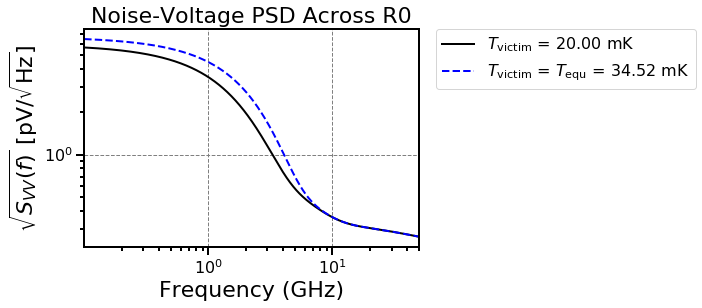

Victim absorbs 517.8 aW ± 690 aW from system over 100.0 MHz to 50.00 GHz
R0 is in thermal equilibrium over 100.0 MHz to 50.00 GHz at 34.52 mK


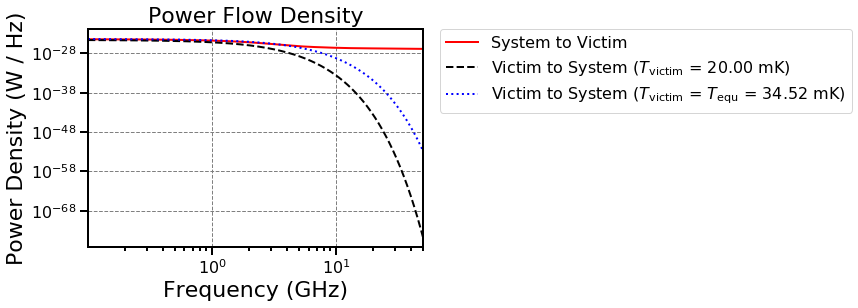

T_ie is the "instantaneous" equilibrium temperature.


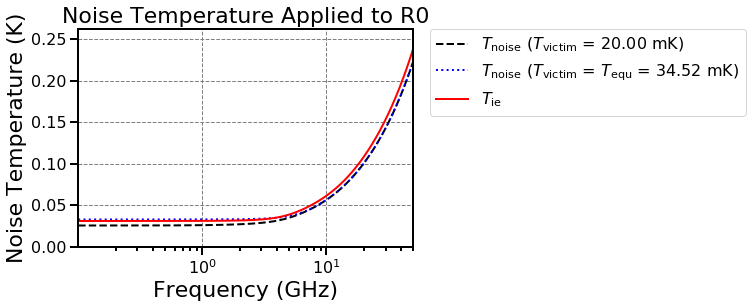

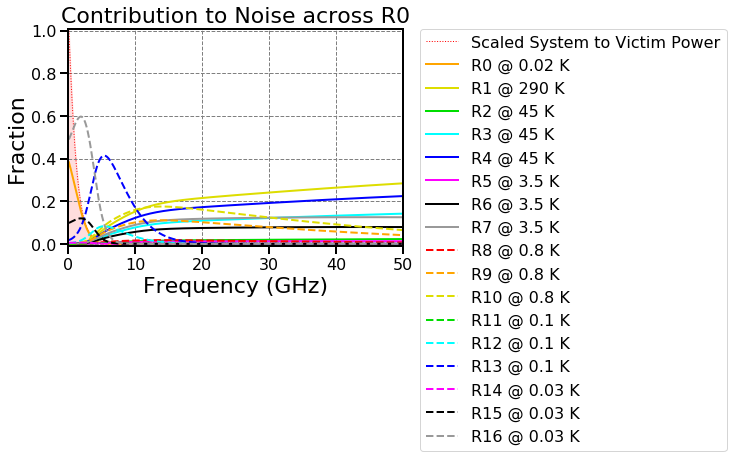

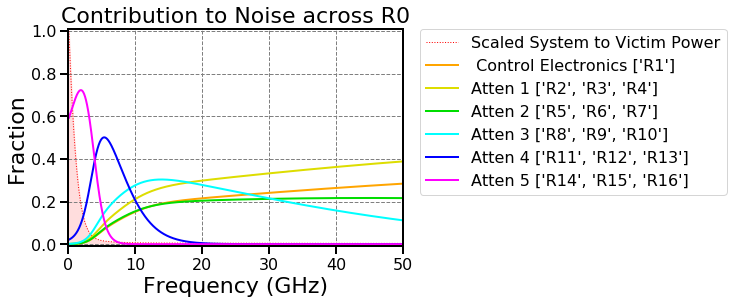

In [6]:
################################################################################
# User input
################################################################################

# SPICE executable; include path if it is not included in search path
# Linux WRspice
spice_cmd = 'wrspice'
# Linux ngspice
#spice_cmd = 'ngspice'
# Windows WRspice
#spice_cmd = r'c:\usr\local\xictools\wrspice.current\bin\wrspice.bat'
# Windows ngspice
#spice_cmd = r'c:\Spice64\bin\ngspice_con.exe' 

# netlist filename for model
path_netlist = '/home/nick/files/Programming/Python_Notebooks/Calculations/Noise/SPICE_noise_examples/'
#fname_netlist = path_netlist + '/Eeschema/1_matched_resistors.cir'
#fname_netlist = path_netlist + '/Eeschema/2_mismatched_resistors.cir'
#fname_netlist = path_netlist + '/Eeschema/3_capacitively_coupled_mismatched_resistors.cir'
fname_netlist = path_netlist + '/Eeschema/4_attenuated_input_line.cir'
#fname_netlist = path_netlist + '/Eeschema/5_attenuated_input_line_with_capacitive_attenuator.cir'
# Windows filename
#fname_netlist = r'C:\SPICE_noise_examples\Eeschema\1_matched_resistors.cir'

# reference designator of component to get noise across
refdes_victim = 'R0'

# Default temperature to apply to any components whose temperature is otherwise
# not defined.
default_temperature = 290

# Optionally define temperatures.  This overrides everything.
# Key is reference designator, value is temperature in Kelvin.
# This dict will be fully populated after make_noise_func_dict() runs.
temperature_dict = {
'R0': 0.02,
}

# Optionally define groups of aggressors into objects (like attenuators).
# Key is group name, value is list of reference designators
aggressor_groups = {
' Control Electronics': ['R1'],
'Atten 1': ['R2', 'R3', 'R4'],
'Atten 2': ['R5', 'R6', 'R7'],
'Atten 3': ['R8', 'R9', 'R10'],
'Atten 4': ['R11', 'R12', 'R13'],
'Atten 5': ['R14', 'R15', 'R16'],
}

# Optionally define temperature of items grouped in aggressor_groups.
# This overrides reference designator temperatures, but not temperatures
# defined in temperature_dict.
# Key is group name, value is temperature in Kelvin
group_temperature_dict = {
'Atten 1': 45,
'Atten 2': 3.5,
'Atten 3': 0.8,
'Atten 4': 0.1,
'Atten 5': 0.03
}

# start frequency
freq_start = 1e8
# stop frequency; actual stop will depend on start and points per decade
freq_stop = 50e9
# points per decade
points_per_dec = 1000

# display results and plots
show_results = True

################################################################################
# Do analysis (do not edit)
################################################################################

# perform analysis
analysis_results = do_analysis(fname_netlist, refdes_victim, freq_start,
                               freq_stop, points_per_dec, temperature_dict,
                               aggressor_groups, group_temperature_dict,
                               spice_cmd, default_temperature)

# display analysis results
if show_results:
    display_results(*analysis_results)

# separate out results into variables for use in analysis by user
netlist, noise_func_dict, temperature_dict, response_dict = analysis_results[:4]
svv_total, noise_ratio_dict, group_noise_ratio_dict = analysis_results[4:7]
power_abs, power_abs_err, noise_sys_to_victim = analysis_results[7:10]
noise_victim_to_sys, noise_equ_victim_to_sys, T_equ_i = analysis_results[10:13]
T_noise, T_noise_equ, T_equ, svv_total_equ = analysis_results[13:]